In [319]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
import statsmodels.formula.api as sm
import warnings 
import itertools

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc

In [320]:
# run this if imlearn not installed
# !pip install imblearn

In [321]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,5

In [322]:
warnings.filterwarnings('ignore')

In [323]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

# Description of Variables

- Age: The age of the employee. (Numerical)
- Attrition: Whether or not the employee has left the organization. (Categorical)
- BusinessTravel: The frequency of business travel for the employee. (Categorical)
- DailyRate: The daily rate of pay for the employee. (Numerical)
- Department: The department the employee works in. (Categorical)
- DistanceFromHome: The distance from home in miles for the employee. (Numerical)
- Education: The level of education achieved by the employee. (Categorical)
- EducationField: The field of study for the employee's education. (Categorical)
- EmployeeCount: The total number of employees in the organization. (Numerical)
- EmployeeNumber: A unique identifier for each employee profile. (Numerical)
- EnvironmentSatisfaction: The employee's satisfaction with their work environment. (Categorical)
- Gender: The gender of the employee. (Categorical)
- HourlyRate: The hourly rate of pay for the employee. (Numerical)
- JobInvolvement: The level of involvement required for the employee's job. (Categorical)
- JobLevel: The job level of the employee. (Categorical)
- JobRole: The role of the employee in the organization. (Categorical)
- JobSatisfaction: The employee's satisfaction with their job. (Categorical)
- MaritalStatus: The marital status of the employee. (Categorical)
- MonthlyIncome: The monthly income of the employee. (Numerical)
- MonthlyRate: The monthly rate of pay for the employee. (Numerical)
- NumCompaniesWorked: The number of companies the employee has worked for. (Numerical)
- Over18: Whether or not the employee is over 18. (Categorical)
- OverTime: Whether or not the employee works overtime. (Categorical)
- PercentSalaryHike: The percentage of salary hike for the employee. (Numerical)
- PerformanceRating: The performance rating of the employee. (Categorical)
- RelationshipSatisfaction: The employee's satisfaction with their relationships. (Categorical)
- StandardHours: The standard hours of work for the employee. (Numerical)
- StockOptionLevel: The stock option level of the employee. (Numerical)
- TotalWorkingYears: The total number of years the employee has worked. (Numerical)
- TrainingTimesLastYear: The number of times the employee was taken for training in the last year. (Numerical)
- WorkLifeBalance: The employee's perception of their work-life balance. (Categorical)
- YearsAtCompany: The number of years the employee has been with the company. (Numerical)
- YearsInCurrentRole: The number of years the employee has been in their current role. (Numerical)
- YearsSinceLastPromotion: The number of years since the employee's last promotion. (Numerical)
- YearsWithCurrManager: The number of years the employee has been with their current manager. (Numerical)

- make people who leave the job 1 (bc there are far less of them)
- min false neg rate to maximizew recall 
- precision recall is a good metric to optimize (most imp recall)
- minimize ppl who will leave

In [324]:
#Load data
df=pd.read_csv("data/HR_Analytics.csv")
df = pd.get_dummies(df, columns = ["Attrition"])
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,...,0,8,0,1,6,4,0,5,0,1
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,...,1,10,3,3,10,7,1,7,1,0
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,...,0,7,3,3,0,0,0,0,0,1
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,...,0,8,3,3,8,7,3,0,1,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,...,1,6,3,3,2,2,2,2,1,0


In [325]:
#Keep the dummy column where employees leaving = 1, because there are far less of them and we want to minimize FNR and recall
df = df.drop(["Attrition_No"], axis = 1)

In [326]:
#Splitting up data into train and test data - train has 70% of values and test has 30%
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=25)

print(f"No. of training examples: {train.shape[0]}")
print(f"No. of testing examples: {test.shape[0]}")

No. of training examples: 1029
No. of testing examples: 441


In [327]:
#Printing the ratio of No's and Yes's to the response variable (Attrition) for train and test to make sure they are similar
print(train.Attrition_Yes.value_counts()[1]/train.Attrition_Yes.value_counts()[0])
print(test.Attrition_Yes.value_counts()[1]/test.Attrition_Yes.value_counts()[0])

0.1937354988399072
0.18867924528301888


In [328]:
#Shape of data
print(train.shape)
print(test.shape)

(1029, 35)
(441, 35)


In [329]:
#There are zero missing values that need to be filled in either data set
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [330]:
#All column names in dataframe
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

In [331]:
#Finding correlations between variables and response
train.corrwith(train.Attrition_Yes).sort_values(ascending = False)

Attrition_Yes               1.000000
DistanceFromHome            0.065658
NumCompaniesWorked          0.029205
MonthlyRate                 0.001126
PerformanceRating          -0.007033
EmployeeNumber             -0.020580
PercentSalaryHike          -0.021023
TrainingTimesLastYear      -0.036240
WorkLifeBalance            -0.039167
Education                  -0.042102
HourlyRate                 -0.044921
YearsSinceLastPromotion    -0.048035
RelationshipSatisfaction   -0.061508
DailyRate                  -0.081930
JobSatisfaction            -0.098817
EnvironmentSatisfaction    -0.113397
JobInvolvement             -0.121431
StockOptionLevel           -0.145659
YearsAtCompany             -0.150960
YearsWithCurrManager       -0.153679
MonthlyIncome              -0.164937
JobLevel                   -0.169904
YearsInCurrentRole         -0.178133
Age                        -0.182642
TotalWorkingYears          -0.185703
EmployeeCount                    NaN
StandardHours                    NaN
d

In [332]:
train.Over18.value_counts()

Y    1029
Name: Over18, dtype: int64

In [333]:
#Drop employee count, over 18 and standard hours because they are the same value for every person
train = train.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
test = test.drop(["EmployeeCount", "StandardHours", "Over18"], axis = 1)
train.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Yes'],
      dtype='object')

 OverTime, JobLevel, StockOptionLevel, JobInvolvement, BusinessTravel, NumCompaniesWorked, JobSatisfaction, EnvironmentSatisfaction, EducationField, WorkLifeBalance, Age, DistanceFromHome, YearsSinceLastPromotion, YearsInCurrentRole, YearsAtCompany, TotalWorkingYears, YearsWithCurrManager, Gender, and PercentSalaryHike

In [334]:
interactions = train.loc[:, ['OverTime', 'JobLevel', 'StockOptionLevel', 'JobInvolvement', 'BusinessTravel', 'NumCompaniesWorked', 'JobSatisfaction', 'EnvironmentSatisfaction', 'EducationField', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'YearsSinceLastPromotion', 'YearsInCurrentRole', 'YearsAtCompany', 'TotalWorkingYears', 'YearsWithCurrManager', 'Gender', 'PercentSalaryHike']]

In [335]:
#sns.pairplot(interactions)

In [336]:
#interaction terms: YearsAtCompany*TotalWorkingYears Age*TotalWorkingYears, Age*YearsAtCompany,

In [337]:
interactions.corr()

,JobLevel,StockOptionLevel,JobInvolvement,NumCompaniesWorked,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,Age,DistanceFromHome,YearsSinceLastPromotion,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears,YearsWithCurrManager,PercentSalaryHike
JobLevel,1.000000,0.006959,-0.009112,0.153544,0.021031,0.006035,0.014191,0.511042,0.011966,0.309912,0.365351,0.497739,0.781987,0.336493,-0.008855
StockOptionLevel,0.006959,1.000000,0.067397,0.018944,0.000795,0.022180,0.026797,0.062264,0.048093,0.007439,0.034791,0.020755,0.011130,0.023468,0.007738
JobInvolvement,-0.009112,0.067397,1.000000,0.018458,-0.016585,-0.033744,0.003785,0.051137,0.003617,-0.005133,0.040467,0.006205,0.024000,0.048525,0.037431
NumCompaniesWorked,0.153544,0.018944,0.018458,1.000000,-0.031017,0.026698,-0.004100,0.299410,-0.051574,-0.064959,-0.095547,-0.134277,0.248273,-0.119842,-0.002508
JobSatisfaction,0.021031,0.000795,-0.016585,-0.031017,1.000000,-0.024880,-0.017535,0.031203,-0.027867,-0.001105,0.010160,0.019719,-0.004279,-0.005361,0.028391
EnvironmentSatisfaction,0.006035,0.022180,-0.033744,0.026698,-0.024880,1.000000,0.027154,0.032225,0.011353,0.005821,-0.017946,-0.013449,0.004853,-0.004627,-0.027728
WorkLifeBalance,0.014191,0.026797,0.003785,-0.004100,-0.017535,0.027154,1.000000,-0.022323,-0.022224,0.004330,0.030942,-0.000269,-0.009416,0.008794,-0.006314
Age,0.511042,0.062264,0.051137,0.299410,0.031203,0.032225,-0.022323,1.000000,-0.019316,0.188573,0.213709,0.291780,0.672094,0.195552,0.029420
DistanceFromHome,0.011966,0.048093,0.003617,-0.051574,-0.027867,0.011353,-0.022224,-0.019316,1.000000,0.019615,0.028074,0.023143,0.004865,0.032785,0.068196
YearsSinceLastPromotion,0.309912,0.007439,-0.005133,-0.064959,-0.001105,0.005821,0.004330,0.188573,0.019615,1.000000,0.569019,0.617816,0.379931,0.527536,0.005186


# Visualizations of initial thoughts on variables that could be correlated

In [338]:
# calculate the null count for each column
null_count = df.isnull().sum()
null_count.name = 'count of null' 

# find the datatype for each column
dtype = df.dtypes
dtype.name = 'data type'

# describe the dataframe to get other statistics
data_desc = df.describe(include='all', datetime_is_numeric=True)

# remove count, freq, mean, std, 25%, 50%, and 75% percentiles
data_desc = data_desc.drop(['count', 'freq', 'std', '25%', '75%', 'top'], axis=0)

# transpose the dataframe to prevent the dataframe from being too wide.
data_desc_T = data_desc.T

# add the row of null count and datatype to the dataframe
data_desc_T = pd.concat([dtype, null_count, data_desc_T], axis=1)

# order the summary statistics table by datatype and count of null
data_desc_T = data_desc_T.sort_values(['data type', 'count of null'])

# show the summary statistics table
data_desc_T

,data type,count of null,unique,mean,min,50%,max
Attrition_Yes,uint8,0,NaN,0.161224,0.0,0.0,1.0
Age,int64,0,NaN,36.92381,18.0,36.0,60.0
DailyRate,int64,0,NaN,802.485714,102.0,802.0,1499.0
DistanceFromHome,int64,0,NaN,9.192517,1.0,7.0,29.0
Education,int64,0,NaN,2.912925,1.0,3.0,5.0
EmployeeCount,int64,0,NaN,1.0,1.0,1.0,1.0
EmployeeNumber,int64,0,NaN,1024.865306,1.0,1020.5,2068.0
EnvironmentSatisfaction,int64,0,NaN,2.721769,1.0,3.0,4.0
HourlyRate,int64,0,NaN,65.891156,30.0,66.0,100.0
JobInvolvement,int64,0,NaN,2.729932,1.0,3.0,4.0


In [339]:
df = df.drop(columns = ['Over18','StandardHours','EmployeeCount'])
# We should just drop these columns because they only have 1 unique values and contain no information

<AxesSubplot:>

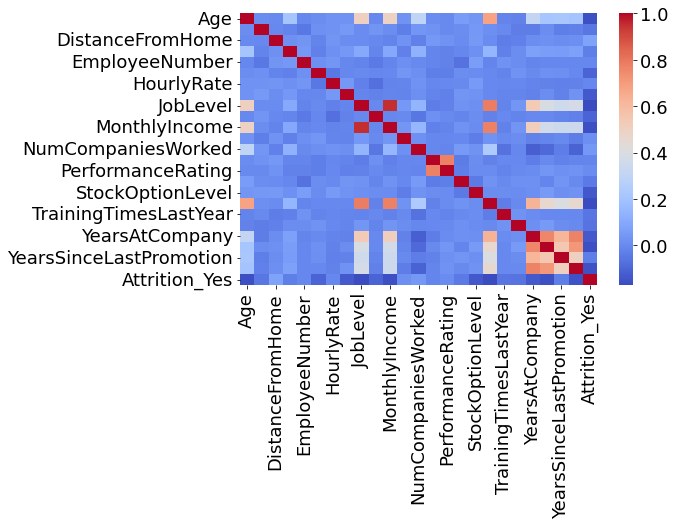

In [340]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')

In [341]:
# count the number of attrition entries
attrition_counts = df['Attrition_Yes'].value_counts()

# calculate the percentage out of total entries
attrition_percent = attrition_counts/attrition_counts.sum()

# make labels for plots
labels = ['Attrition_No-'+str((attrition_percent[0]*100).round(2))+'%', 'Attrition_Yes-'+str((attrition_percent[1]*100).round(2))+'%']

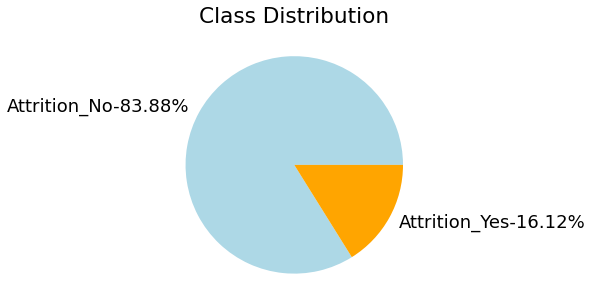

In [342]:
# check for class imbalance of the outcome variable
plt.pie(attrition_counts, labels=labels, colors=['lightblue', 'orange'])
plt.title('Class Distribution')
plt.show()

class imbalance in the outcome variable, maybe do resampling techniques: This involves either oversampling the minority class by duplicating existing examples or undersampling the majority class by reducing the number of examples. Common resampling techniques include random oversampling, random undersampling, and Synthetic Minority Over-sampling Technique (SMOTE). Do this before training the model

<AxesSubplot:xlabel='Attrition_Yes', ylabel='MonthlyIncome'>

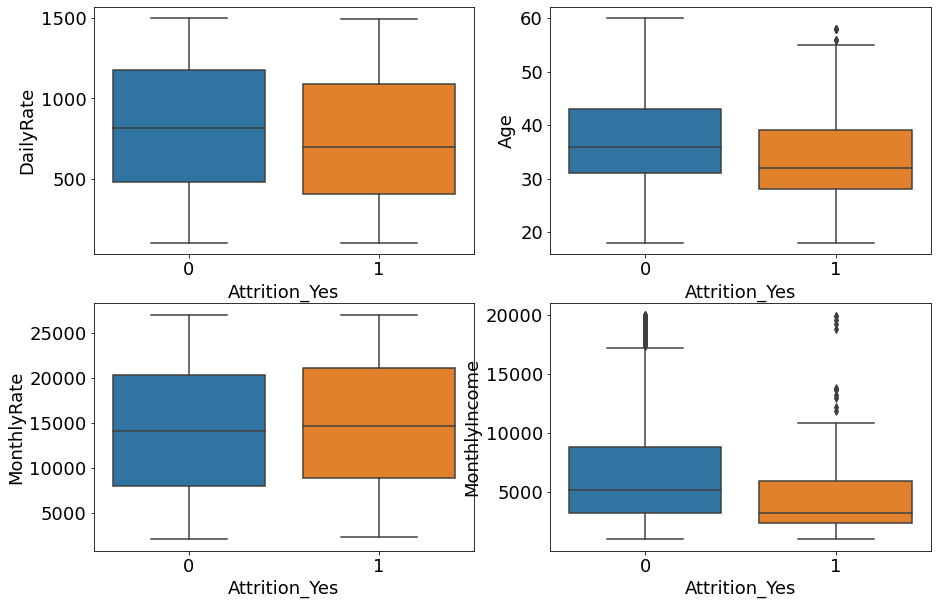

In [343]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.boxplot(data=df, x='Attrition_Yes', y='DailyRate', ax=axes[0, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='Age', ax=axes[0, 1])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyRate', ax=axes[1, 0])
sns.boxplot(data=df, x='Attrition_Yes', y='MonthlyIncome', ax=axes[1, 1])

In machine learning, having a class imbalance problem can lead to biased models and poor predictive performance. If one class has significantly fewer examples than the other classes, the model may not learn enough from the minority class and may struggle to generalize well to new data.
In our case, having only 16% of Attrition = Yes suggests that our dataset has a significant class imbalance. This can lead to issues such as too many false negatives and reduced model performance overall.
To address this class imbalance problem, we chose to oversample the minority class, as shown in the code below.

In [344]:
# separate the target variable and predictor variables
X = df.drop(columns = ['Attrition_Yes'], axis=1)
y = df['Attrition_Yes']

In [345]:
X = X.rename(columns=lambda x: x.strip())

X = pd.get_dummies(X, drop_first = True)
X.columns = X.columns.str.replace('-', '')
X.columns = X.columns.str.replace(' ', '')
X.columns = X.columns.str.replace('&', '_')

X

,Age,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,1,2,94,3,2,4,...,0,0,0,0,0,1,0,0,1,1
1,49,279,8,1,2,3,61,2,2,2,...,0,0,0,0,1,0,0,1,0,0
2,37,1373,2,2,4,4,92,2,1,3,...,1,0,0,0,0,0,0,0,1,1
3,33,1392,3,4,5,4,56,3,1,3,...,0,0,0,0,1,0,0,1,0,1
4,27,591,2,1,7,1,40,3,1,2,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,2061,3,41,4,2,4,...,1,0,0,0,0,0,0,1,0,0
1466,39,613,6,1,2062,4,42,2,3,1,...,0,0,0,0,0,0,0,1,0,0
1467,27,155,4,3,2064,2,87,4,2,2,...,0,0,1,0,0,0,0,1,0,1
1468,49,1023,2,3,2065,4,63,2,2,2,...,0,0,0,0,0,1,0,1,0,0


In [346]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# print the number of examples in each class before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling:")
print(y_train_resampled.value_counts())

Before oversampling:
0    978
1    198
Name: Attrition_Yes, dtype: int64
After oversampling:
0    978
1    978
Name: Attrition_Yes, dtype: int64


In [347]:
y_train_resampled.name = 'Attrition_Yes'

# Checking VIF, dropping variables with VIF>10 1-by-1

In [348]:
# check for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  596.631312
1                                Age    2.193194
2                          DailyRate    1.079127
3                   DistanceFromHome    1.085088
4                          Education    1.131678
5                     EmployeeNumber    1.067639
6            EnvironmentSatisfaction    1.067232
7                         HourlyRate    1.053239
8                     JobInvolvement    1.065647
9                           JobLevel   15.426832
10                   JobSatisfaction    1.072875
11                     MonthlyIncome   18.192908
12                       MonthlyRate    1.096248
13                NumCompaniesWorked    1.339920
14                 PercentSalaryHike    2.590110
15                 PerformanceRating    2.566481
16          RelationshipSatisfaction    1.060952
17                  StockOptionLevel    1.984369
18                 TotalWorkingYears    5.441899
19             Train

In [349]:
# Drop the feature with the greatest VIF (Department_Reearch_Development)
col_to_drop = ["Department_Research_Development"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [350]:
#Retesting VIF without Department_Research_Development
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.460687
1                                Age    2.193194
2                          DailyRate    1.079122
3                   DistanceFromHome    1.083467
4                          Education    1.130747
5                     EmployeeNumber    1.067608
6            EnvironmentSatisfaction    1.066861
7                         HourlyRate    1.053187
8                     JobInvolvement    1.064846
9                           JobLevel   15.418660
10                   JobSatisfaction    1.072872
11                     MonthlyIncome   18.184693
12                       MonthlyRate    1.094678
13                NumCompaniesWorked    1.337916
14                 PercentSalaryHike    2.588563
15                 PerformanceRating    2.566358
16          RelationshipSatisfaction    1.059649
17                  StockOptionLevel    1.984009
18                 TotalWorkingYears    5.423582
19             Train

In [351]:
# Drop the feature with the greatest VIF (Department_Sales)
col_to_drop = ["Department_Sales"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [352]:
#Retesting VIF without Department_Sales
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  354.426165
1                                Age    2.192868
2                          DailyRate    1.078610
3                   DistanceFromHome    1.083052
4                          Education    1.130226
5                     EmployeeNumber    1.067222
6            EnvironmentSatisfaction    1.064463
7                         HourlyRate    1.053035
8                     JobInvolvement    1.061979
9                           JobLevel   15.413640
10                   JobSatisfaction    1.072613
11                     MonthlyIncome   18.153276
12                       MonthlyRate    1.094675
13                NumCompaniesWorked    1.337682
14                 PercentSalaryHike    2.580733
15                 PerformanceRating    2.563686
16          RelationshipSatisfaction    1.059632
17                  StockOptionLevel    1.983423
18                 TotalWorkingYears    5.423571
19             Train

In [353]:
# Drop the feature with the greatest VIF (EducationField_LifeSciences)
col_to_drop = ["EducationField_LifeSciences"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [354]:
#Retesting VIF without EducationField_LifeSciences
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  275.768048
1                                Age    2.192837
2                          DailyRate    1.077953
3                   DistanceFromHome    1.082457
4                          Education    1.128636
5                     EmployeeNumber    1.066762
6            EnvironmentSatisfaction    1.063689
7                         HourlyRate    1.051971
8                     JobInvolvement    1.061926
9                           JobLevel   15.412618
10                   JobSatisfaction    1.072306
11                     MonthlyIncome   18.152727
12                       MonthlyRate    1.092353
13                NumCompaniesWorked    1.335664
14                 PercentSalaryHike    2.580235
15                 PerformanceRating    2.563067
16          RelationshipSatisfaction    1.059580
17                  StockOptionLevel    1.982964
18                 TotalWorkingYears    5.421276
19             Train

In [355]:
# Drop the feature with the greatest VIF (MonthlyIncome)
col_to_drop = ["MonthlyIncome"]
X_train_resampled = X_train_resampled.drop(col_to_drop, axis=1)

In [356]:
#Retesting VIF without MonthlyIncome
Var = X_train_resampled[X_train_resampled.columns]
Var = add_constant(Var)
vif_data = pd.DataFrame()
vif_data["feature"] = Var.columns

for i in range(len(Var.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(Var.values, i)

print(vif_data)

                             feature         VIF
0                              const  275.492166
1                                Age    2.191315
2                          DailyRate    1.073006
3                   DistanceFromHome    1.080057
4                          Education    1.128636
5                     EmployeeNumber    1.065420
6            EnvironmentSatisfaction    1.060994
7                         HourlyRate    1.051374
8                     JobInvolvement    1.056253
9                           JobLevel    7.017367
10                   JobSatisfaction    1.069075
11                       MonthlyRate    1.092300
12                NumCompaniesWorked    1.334593
13                 PercentSalaryHike    2.578916
14                 PerformanceRating    2.559941
15          RelationshipSatisfaction    1.059004
16                  StockOptionLevel    1.982880
17                 TotalWorkingYears    5.337605
18             TrainingTimesLastYear    1.058063
19                  

In [357]:
train = pd.concat([X_train_resampled, pd.DataFrame(y_train_resampled)],axis =1)

In [358]:
column_list = train.columns.to_list()[:-1] #not including Attrition
column_list

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_TechnicalDegree',
 'Gender_Male',
 'JobRole_HumanResources',
 'JobRole_LaboratoryTechnician',
 'JobRole_Manager',
 'JobRole_ManufacturingDirector',
 'JobRole_ResearchDirector',
 'JobRole_ResearchScientist',
 'JobRole_SalesExecutive',
 'JobRole_SalesRepresentative',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'OverTime_Yes']

In [359]:
formula = 'Attrition_Yes~'+'+'.join(column_list)

In [360]:
#logistic regression with all predictors
logit_model = smf.logit(formula=formula, data=train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Attrition_Yes   No. Observations:                 1956
Model:                          Logit   Df Residuals:                     1914
Method:                           MLE   Df Model:                           41
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.3797
Time:                        13:02:39   Log-Likelihood:                -841.02
converged:                       True   LL-Null:                       -1355.8
Covariance Type:            nonrobust   LLR p-value:                3.929e-189
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9725      1.039      0.936      0.349      -1.063       3.008
Age                                 -0.0196      0.009     -2.075      0.038      -0.038      -0.001
DailyRate                           -0.0002      0.000     -1.381      0.167      -0.001    9.35e-05
DistanceFromHome                     0.0416      0.008      5.253      0.000       0.026       0.057
Education                            0.0385      0.062      0.622      0.534      -0.083       0.160
EmployeeNumber                   -1.943e-05      0.000     -0.182      0.856      -0.000       0.000
EnvironmentSatisfaction             -0.3797      0.060     -6.308      0.000      -0.498      -0.262
HourlyRate                           0.0017      0.003      0.529      0.597      -0.005       0.008
JobInvolvement                      -0.4697      0.091     -5.164      0.000      -0.648      -0.291
JobLevel                             0.2208      0.161      1.368      0.171      -0.096       0.537
JobSatisfaction                     -0.3430      0.059     -5.826      0.000      -0.458      -0.228
MonthlyRate                       1.637e-05   8.86e-06      1.847      0.065      -1e-06    3.37e-05
NumCompaniesWorked                   0.1910      0.028      6.922      0.000       0.137       0.245
PercentSalaryHike                   -0.0491      0.027     -1.815      0.069      -0.102       0.004
PerformanceRating                   -0.0986      0.280     -0.353      0.724      -0.647       0.450
RelationshipSatisfaction            -0.1318      0.057     -2.307      0.021      -0.244      -0.020
StockOptionLevel                    -0.1489      0.101     -1.471      0.141      -0.347       0.050
TotalWorkingYears                   -0.0855      0.020     -4.286      0.000      -0.125      -0.046
TrainingTimesLastYear               -0.1464      0.049     -2.979      0.003      -0.243      -0.050
WorkLifeBalance                     -0.4767      0.088     -5.420      0.000      -0.649      -0.304
YearsAtCompany                       0.1870      0.024      7.870      0.000       0.140       0.234
YearsInCurrentRole                  -0.1993      0.033     -6.121      0.000      -0.263      -0.135
YearsSinceLastPromotion              0.1320      0.028      4.738      0.000       0.077       0.187
YearsWithCurrManager                -0.1497      0.030     -4.993      0.000      -0.209      -0.091
BusinessTravel_Travel_Frequently     1.7815      0.282      6.308      0.000       1.228       2.335
BusinessTravel_Travel_Rarely         1.0784      0.257      4.190      0.000       0.574       1.583
EducationField_Marketing             0.1489      0.248      0.601      0.548      -0.337       0.634
EducationField_Medical               0.2453      0.149      1.643      0.100      -0.047       0.538
EducationField_Other                 0.6779      0.265      2.556      0.011       0.158       1.198
Education

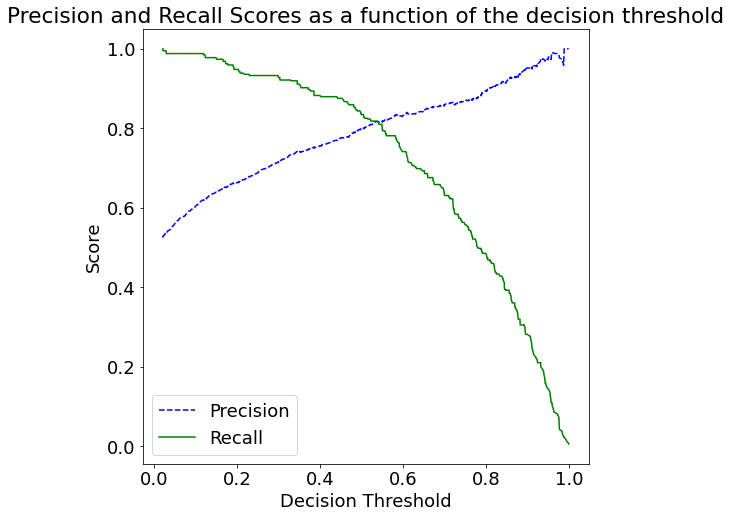

In [361]:
from sklearn.metrics import precision_recall_curve
y=train.Attrition_Yes
ypred = logit_model.predict(train)
p, r, thresholds = precision_recall_curve(y, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Classification accuracy = 80.9%
Precision = 81.7%
TPR or Recall = 79.7%
FNR = 20.3%
FPR = 17.8%
ROC-AUC = 88.3%


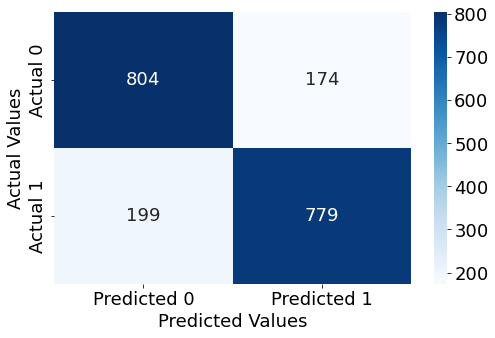

In [362]:
confusion_matrix_data(train,train.Attrition_Yes,logit_model,0.55)

0.8830027475629493


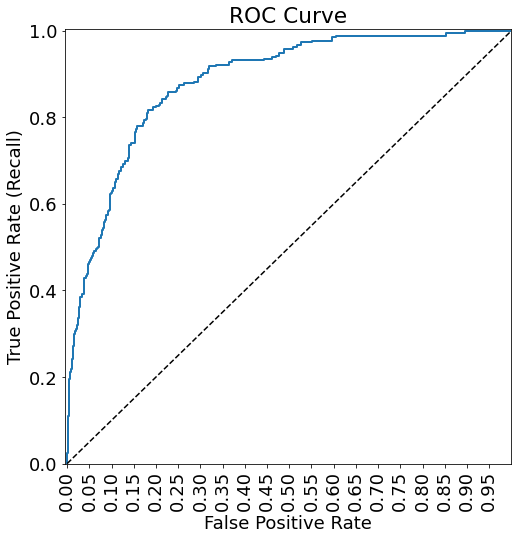

In [363]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

maybe another model with interaction terms and other transformations

In [367]:
# len(X_train_resampled.columns)
# train1 = train.drop(['Attrition_Yes'], axis = 1)
# train1.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_TechnicalDegree', 'Gender_Male',
       'JobRole_HumanResources', 'JobRole_LaboratoryTechnician',
       'JobRole_Manager', 'JobRole_ManufacturingDirector',
       'JobRole_ResearchDirector', 'JobRole_ResearchScientist',
       'JobRole_SalesExecutive', 'JobRole_SalesRepresentative',
       'MaritalStatus_Married', 'Marita

In [368]:
X_backup = X_train_resampled.copy()
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    #test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X_train_resampled.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

In [370]:
len(X_train_resampled.columns)

861

In [97]:
#Function to develop a model based on all predictors in predictor_subset
# X = train.drop(["Attrition_Yes",'JobRole','OverTime'], axis = 1)
## X = X.rename(columns=lambda x: x.strip())
## X['JobRole'] = X['JobRole'].astype(str)

train = train.apply(lambda x: x.str.strip() if isinstance(x.iloc[0], str) else x)
def processSubset(predictor_subset):
    if 'Attrition_Yes' in predictor_subset:
        predictor_subset = predictor_subset.remove('Attrition_Yes')

    # Fit model on feature_set and calculate R-squared
    #model = sm.ols('Attrition_Yes~' + '+'.join(predictor_subset),data = train_num).fit()
    #Developing logistic regression model
    logit_model = sm.logit(formula = 'Attrition_Yes~' + '+'.join(predictor_subset),data = train).fit() 
    llf = logit_model.llf
    return {"logit_model":logit_model, "Log-Likelihood":llf}

In [98]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
import time
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train_resampled.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Log-Likelihood'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [99]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Log-Likelihood", "logit_model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X_train_resampled.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["logit_model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

#make dummies for all categorical variables
#change R-squared to log likelihood, keep AIC and BIC
#show all three graphs in
#check for multi-collinearity among all variables first, remove the ones that are colinear (decide which one is most important), then do forward stepwise - use VIF score, (email Krish about what threshold to use, 5 and below you should be good) if they're above the threshold point, remove them
#change predictors to be dummies rather than just dummy variables because forward selection might decide that one of them isn't important and not include them - less of a priority, but if we have time

In [100]:
models_best = forward_selection()

Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689421
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692107
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693004
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688763
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692620
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.682307
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.658104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686367
  

Optimization terminated successfully.
         Current function value: 0.601802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.602569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.596939
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.587422
  

Optimization terminated successfully.
         Current function value: 0.565292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.558940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.563072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564821
         Iterations 6
Processed  37 models on 5 predictors in 0.3877248764038086 seconds.
Optimization t

Optimization terminated successfully.
         Current function value: 0.539829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542279
  

         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523664
         Iterations 6
Processed  32 models on 10 predictors in 0.45641183853149414 seconds.
Optimization terminated successfully.
         Current function value: 0.519045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519784
         Ite

Optimization terminated successfully.
         Current function value: 0.501652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501988
  

Optimization terminated successfully.
         Current function value: 0.488925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.487793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485716
         Iterations 6
Processed  26 models on 16 predictors in 0.44236278533935547 seconds.
Optimization terminated successfully.
         Current function value: 0.479311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481802
         Iterations 6
Optimization

Optimization terminated successfully.
         Current function value: 0.461995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.460433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461445
  

Optimization terminated successfully.
         Current function value: 0.450351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.449681
  

Optimization terminated successfully.
         Current function value: 0.435559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436628
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435338
         Iterations 7
Processed  13 models on 29 predictors in 0.34394073486328125 seconds.
Optimization terminated successfully.
         Current function value: 0.434891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435230
         Iterations 7
Optimization

Optimization terminated successfully.
         Current function value: 0.430036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430007
         Iterations 7
Processed  3 models on 39 predictors in 0.103759765625 seconds.
Optimization terminated successfully.
         Current function value: 0.429999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.429976
         Iterations 7
Processed  2 models on 40 predictors in 0.07123112678527832 seconds.
Optimization terminated successfully.
         Current function value: 0.429967
         Iterations 7
Processed  1 models on 41 predictors in 0.04095005989074707 seconds.
Total elapsed time: 14.246513843536377 seconds.


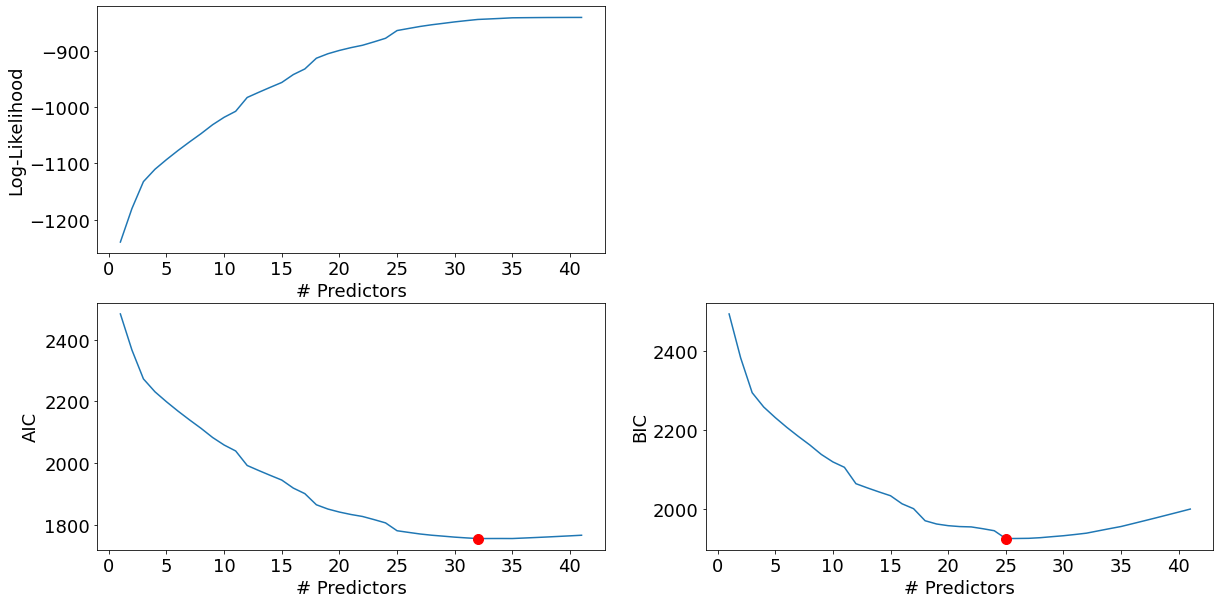

In [101]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Log-Likelihood"])
    plt.xlabel('# Predictors')
    plt.ylabel('Log-Likelihood')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    """
    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('psuedo rsquared')
    """

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [ ]:
best_fwd_reg_model = models_best['logit_model'][25]
best_fwd_reg_model.summary()

In [ ]:
confusion_matrix_data(train,train.Attrition_Yes,best_fwd_reg_model,0.55)

In [ ]:
# confusion_matrix_test(test,test.Attrition_Yes,best_fwd_reg_model,0.55)

In [ ]:
from sklearn.metrics import roc_curve, auc
y=train.Attrition_Yes
ypred = best_fwd_reg_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

# Adding interactions and transformations

In [ ]:
best_fwd_reg_model = smf.logit(formula = "Attrition_Yes")

In [ ]:
#interactions: consider all possible - do what we did in Assignment E, include all 2 interactions with stepwise
#might consider 3-factor interactions
#don't do interactions for variables that are the same level

# Ways we improved the model with all predictors
- checked for correlated variables (VIF >10), dropped the correlated variables 1-by-1 until there was no correlation >10

# Final Model ATM: logit_model_TotalWorkingYears